**This notebook shows how to run the inference in the training-time two-view settings on the validation or training set of CMU to visualize the training metrics and losses.**

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from omegaconf import OmegaConf

from pixloc import run_CMU
from pixloc.pixlib.datasets.cmu import CMU
from pixloc.pixlib.datasets.drs import DRS
from pixloc.pixlib.utils.tensor import batch_to_device, map_tensor
from pixloc.pixlib.utils.tools import set_seed
from pixloc.pixlib.utils.experiments import load_experiment
from pixloc.visualization.viz_2d import (
    plot_images, plot_keypoints, plot_matches, cm_RdGn,
    features_to_RGB, add_text)

torch.set_grad_enabled(False);
mpl.rcParams['image.interpolation'] = 'bilinear'

# Create a validation or training dataloader

In [2]:
conf = {
    'min_overlap': 0.3,
    'max_overlap': 1.0,
    'max_num_points3D': 512,
    'force_num_points3D': True,
    'batch_size': 1,
    'min_baseline': 1.,
    'max_baseline': 7.,
    
    'resize': 720,
    'resize_by': 'min',
    'crop': 720,
    'optimal_crop': False,
    'seed': 1,
    'num_workers': 0,
}
# dataset = CMU(conf)
dataset = DRS({})
loader = dataset.get_data_loader('val', shuffle=True)  # or 'train'

[12/01/2021 17:22:14 pixloc.pixlib.datasets.base_dataset INFO] Creating dataset DRS


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/correspondences.json'

# Load the training experiment

In [ ]:
# Name of the example experiment. Replace with your own training experiment.
exp = "pixloc_author_reference" #run_CMU.experiment
device = 'cpu'
conf = {
    'normalize_dt': False, 
    'optimizer': {'num_iters': 20,},
}
refiner = load_experiment(exp, conf).to(device)
print(OmegaConf.to_yaml(refiner.conf))

# Simple logger to store the optimization steps

In [3]:
class Logger:
    def __init__(self, optimizers=None):
        self.costs = []
        self.dt = []
        self.p2D_trajectory = []
        
        if optimizers is not None:
            for opt in optimizers:
                opt.logging_fn = self.log

    def log(self, **args):
        if args['i'] == 0:
            self.costs.append([])
        self.costs[-1].append(args['cost'].mean(-1).cpu().numpy())
        self.dt.append(args['T_delta'].magnitude()[1].cpu().numpy())
        p2D, valid = data_['query']['camera'].world2image(args['T'] * data_['ref']['points3D'])
        self.p2D_trajectory.append((p2D[0].cpu().numpy(), valid[0].cpu().numpy()))

# Run on a few examples

In [4]:
logger = Logger(refiner.optimizer)

set_seed(50)
for _, data in zip(range(1), loader):
    data_ = batch_to_device(data, device)
    pred_ = refiner(data_)
    pred = map_tensor(pred_, lambda x: x[0].cpu())
    data = map_tensor(data, lambda x: x[0].cpu())
    cam_q = data['query']['camera']
    p3D_r = data['ref']['points3D']
        
    p2D_r, valid_r = data['ref']['camera'].world2image(p3D_r)
    p2D_q_gt, valid_q = cam_q.world2image(data['T_r2q_gt'] * p3D_r)
    p2D_q_init, _ = cam_q.world2image(data['T_r2q_init'] * p3D_r)
    p2D_q_opt, _ = cam_q.world2image(pred['T_r2q_opt'][-1] * p3D_r)
    valid = valid_q & valid_r
    
    losses = refiner.loss(pred_, data_)
    mets = refiner.metrics(pred_, data_)
    errP = f"ΔP {losses['reprojection_error/init'].item():.2f} -> {losses['reprojection_error'].item():.3f} px; "
    errR = f"ΔR {mets['R_error/init'].item():.2f} -> {mets['R_error'].item():.3f} deg; "
    errt = f"Δt {mets['t_error/init'].item():.2f} -> {mets['t_error'].item():.3f} m"
    print(errP, errR, errt)

    imr, imq = data['ref']['image'].permute(1, 2, 0), data['query']['image'].permute(1, 2, 0)
    n_points_plot = -1
    plot_images([imr, imq],
                dpi=100,  # set to 100-200 for higher res
                titles=[(data['scene'].item(), valid_r.sum().item(), valid_q.sum().item()), errP+errt])
    plot_keypoints([p2D_r[valid_r][:n_points_plot], p2D_q_gt[valid][:n_points_plot]], colors=[cm_RdGn(valid[valid_r][:n_points_plot]), 'lime'])
    plot_keypoints([np.empty((0, 2)), p2D_q_init[valid][:n_points_plot]], colors='red')
    plot_keypoints([np.empty((0, 2)), p2D_q_opt[valid][:n_points_plot]], colors='blue')
    add_text(0, 'reference')
    add_text(1, 'query')

#     continue
    for i, (F0, F1) in enumerate(zip(pred['ref']['feature_maps'], pred['query']['feature_maps'])):
        C_r, C_q = pred['ref']['confidences'][i][0], pred['query']['confidences'][i][0]
        plot_images([C_r, C_q], cmaps=mpl.cm.turbo, dpi=100)
        add_text(0, f'Level {i}')
        
        axes = plt.gcf().axes
        axes[0].imshow(imr, alpha=0.2, extent=axes[0].images[0]._extent)
        axes[1].imshow(imq, alpha=0.2, extent=axes[1].images[0]._extent)
        plot_images(features_to_RGB(F0.numpy(), F1.numpy(), skip=1), dpi=100)

NameError: name 'refiner' is not defined

# Cost profile and point trajectories

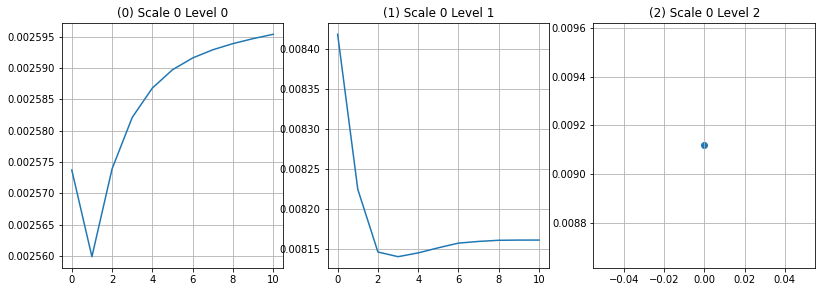

In [15]:
costs = logger.costs
fig, axes = plt.subplots(1, len(costs), figsize=(len(costs)*4.5, 4.5))
for i, (ax, cost) in enumerate(zip(axes, costs)):
    ax.plot(cost) if len(cost)>1 else ax.scatter(0., cost)
    ax.set_title(f'({i}) Scale {i//3} Level {i%3}')
    ax.grid()

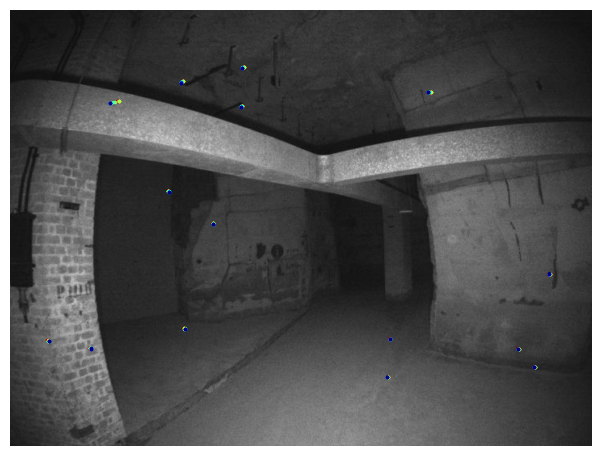

In [16]:
idxs = np.random.RandomState(0).choice(np.where(valid)[0], 15, replace=False)
colors = mpl.cm.jet(1-np.linspace(0, 1, len(logger.p2D_trajectory)))[:, :3]
plot_images([imq])
for (p2D, _), c in zip(logger.p2D_trajectory, colors):
    plot_keypoints([p2D[idxs]], colors=c[None])